In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
crescent = pd.read_csv("C:/Users/bened/Documents/University Files/SchoenStats/PyTorch Working Directory/DreamyDatasets/crescent.csv")
crescent.info()

# random sample from dataset
X = crescent.sample(1000).reset_index(drop=True)
X_data = torch.tensor(X.values)
X = crescent.sample(200).reset_index(drop=True)
t_data = torch.tensor(X.values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       10000 non-null  float64
 1   t       10000 non-null  float64
dtypes: float64(2)
memory usage: 156.4 KB


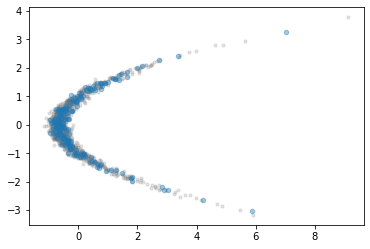

In [3]:
# plot generated dataset

plt.scatter(X_data[:,0], X_data[:,1], alpha=0.2, s=10, color='grey')
plt.scatter(t_data[:,0], t_data[:,1], alpha=0.4, s=20)
plt.show()

In [4]:
# create features data and target data
X_data = X_data.view(-1,2)
t_data = t_data.view(-1,2)

In [5]:
n_input = 1
n_output = 1
# initialise model
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        
        self.z_h = nn.Sequential(nn.Linear(n_input, n_hidden),nn.Tanh())
        
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
    
    def forward(self, x):
        z_h = self.z_h(x)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma

model = MDN(n_hidden=5, n_gaussians=2)

optimizer = torch.optim.Adam(model.parameters())

In [6]:
# modification to the error loss function (because it is an MDN)
def mdn_loss_fn(y, mu, sigma, pi):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=1)
    loss = -torch.log(loss)
    return torch.mean(loss)

In [7]:
# training step
num_epoch = 1000
batch_size = 128

model=model.double()
loss_list = []

for epoch in tqdm(range(num_epoch)): 
    permu = torch.randperm(X_data.shape[0])
    
    for i in range(0, X_data.shape[0], batch_size):
        indices = permu[i:i+batch_size]
        batch_x, batch_y = X_data[indices,0], X_data[indices,1]
        pi, mu, sigma = model.forward(batch_x.unsqueeze(1))
        optimizer.zero_grad()
        l = mdn_loss_fn(batch_y.unsqueeze(1), mu, sigma, pi)
        l.backward()
        optimizer.step()

    if epoch % 100 == 0:
        loss_list.append(l.detach())
        
loss_list

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.26it/s]


[tensor(1.6117, dtype=torch.float64),
 tensor(1.1192, dtype=torch.float64),
 tensor(0.2017, dtype=torch.float64),
 tensor(0.1825, dtype=torch.float64),
 tensor(0.2280, dtype=torch.float64),
 tensor(0.2734, dtype=torch.float64),
 tensor(0.1599, dtype=torch.float64),
 tensor(0.2195, dtype=torch.float64),
 tensor(0.2083, dtype=torch.float64),
 tensor(0.0609, dtype=torch.float64)]

In [8]:
pi, mu, sigma = model(t_data[:,0].unsqueeze(1))

In [9]:
n_samples = 200
k = torch.multinomial(pi, 1).view(-1)
t_pred = torch.normal(mu, sigma)[np.arange(n_samples), k].data
t_pred = t_pred.view(-1, 1)

In [10]:
full_res = torch.cat((t_data, t_pred, pi, mu, sigma), dim=1).detach().numpy()
full_res = pd.DataFrame(full_res, columns=("X", "T", "T_pred",
                                           "pi_1", "pi_2",
                                           "mu_1", "mu_2",
                                           "sigma_1", "sigma_2"))
full_res = full_res.sort_values(by='X', axis=0)
full_res['pi'] = ""

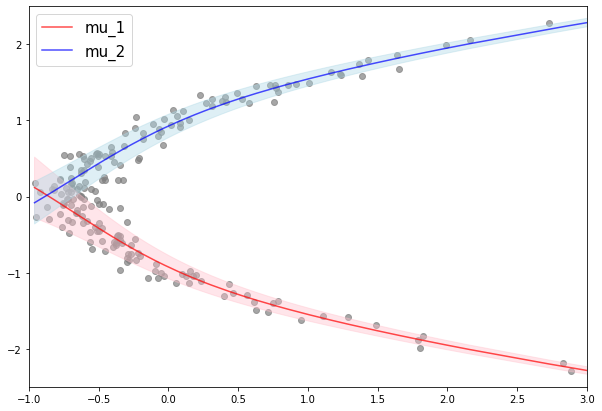

In [22]:
plt.figure(figsize=[10, 7])
plt.scatter(full_res['X'], full_res['T'], alpha=0.7, color='grey')

plt.plot(full_res['X'], full_res['mu_1'], color='red', alpha=0.7, label='mu_1')
plt.fill_between(full_res['X'],
                 full_res['mu_1']+full_res['sigma_1'],
                 full_res['mu_1']-full_res['sigma_1'],
                 alpha=0.4, color='pink')

plt.plot(full_res['X'], full_res['mu_2'], color='blue', alpha=0.7, label='mu_2')
plt.fill_between(full_res['X'],
                 full_res['mu_2']+full_res['sigma_2'],
                 full_res['mu_2']-full_res['sigma_2'],
                 alpha=0.4, color='lightblue')

plt.xlim([-1, 3])
plt.ylim([-2.5, 2.5])
plt.legend(loc='upper left', prop={'size':15})

fig = plt.gcf()
fig.savefig("MDN_mu_crescent.png")
plt.draw()
plt.show()

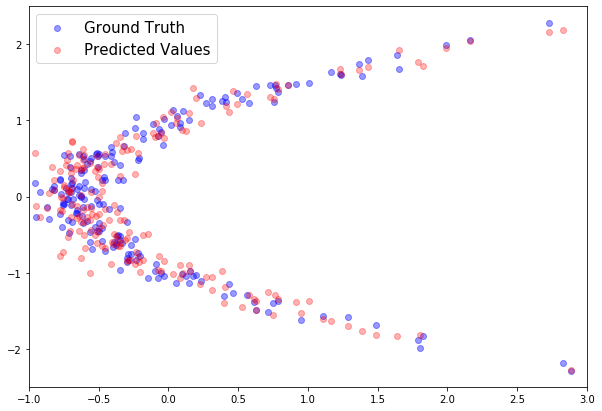

In [23]:
plt.figure(figsize=[10, 7])
plt.scatter(t_data[:,0], t_data[:,1], alpha = 0.4, color = 'blue', label='Ground Truth')
plt.scatter(t_data[:,0], t_pred.detach(), alpha = 0.3, color = 'red', label = 'Predicted Values')
plt.legend(loc='upper left')

plt.xlim([-1, 3])
plt.ylim([-2.5, 2.5])
plt.legend(loc='upper left', prop={'size':15})

fig = plt.gcf()
fig.savefig("MDN_pred_crescent.png")
plt.draw()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
